In [3]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
import os

In [4]:
# Function to backtest the model
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [5]:
# Function to make predictions
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [6]:
# Check if the data file exists, otherwise download it
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [7]:
# Preprocess the data
sp500.index = pd.to_datetime(sp500.index)
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()

In [8]:
# Define predictors
predictors = ["Close", "Volume", "Open", "High", "Low"]

In [9]:
# Create initial model
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [10]:
# Train-test split
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]


In [11]:
# Fit and evaluate the initial model
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])
precision = precision_score(test["Target"], preds)
print("Initial Model Precision Score:", precision)

Initial Model Precision Score: 0.4925373134328358


In [12]:
# Cross-validation
precision_scorer = make_scorer(precision_score)
cv_scores = cross_val_score(model, sp500[predictors], sp500["Target"], cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores:", cv_scores)
print("Mean Precision Score:", cv_scores.mean())

Cross-Validation Precision Scores: [0.53446262 0.5        0.50121655 0.51980198 0.53508772]
Mean Precision Score: 0.5181137722661722


In [13]:
# Generate new predictors
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    new_predictors += [ratio_column, trend_column]

In [14]:
# Drop NaN rows
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [15]:
# Create a new model
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [16]:
# Backtest with new predictors
predictions = backtest(sp500, model, new_predictors)

In [17]:
# Evaluate the new model
precision = precision_score(predictions["Target"], predictions["Predictions"])
print("New Model Precision Score:", precision)

New Model Precision Score: 0.572289156626506


In [18]:
# Check class distribution in predictions
class_distribution = predictions["Predictions"].value_counts() / predictions.shape[0]
print("Class Distribution in Predictions:", class_distribution)


Class Distribution in Predictions: 0.0    0.835839
1.0    0.164161
Name: Predictions, dtype: float64


<Axes: xlabel='Date'>

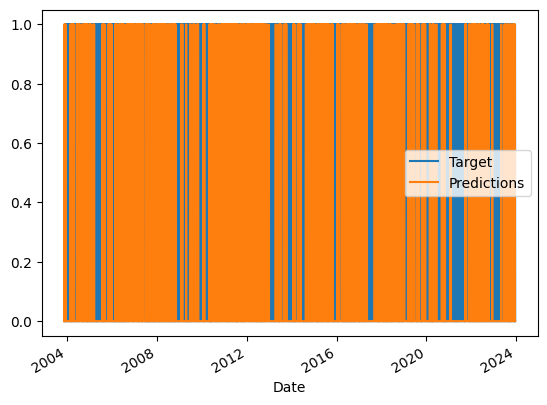

In [19]:
# Plot the results
combined = pd.concat([predictions["Target"], predictions["Predictions"]], axis=1)
combined.plot()